<h1 style="max-width: 450px; margin: auto; text-align: center;">
    Financial Fraud Detection with Graph Neural Networks and Quantum Graph Neural Networks
</h1>

This project, by Erik Staszewski under the supervision of David Redmond for Equal1, seeks to implement and extend quantum computing techniques for credit card fraud detection.

The project focuses on constructing a Graph Neural Network (GNN) and Quantum Graph Neural Network (QGNN) for binary classification of fraudulent and non-fraudulent credit card transactions. Results are measured and compared using precision, recall, and 
$F_1$-scores, and plotted using Receiver Operating Characteristic and Precision-Recall Curves.

## Dataset

The dataset, *creditcard.csv*, contains 284,807 credit card transactions by European cardholders recorded over a period of 48 hours in September 2013. Out of these transactions, 492 (0.172%) are classified as fraudulent. The dataset contains 31 features, they are as follows:

* **Time**: Seconds elapsed since the first transaction.
* **V1 - V28**: Principal components obtained via PCA.
* **Amount**: Transaction amount in Euros.
* **Class**: Target variable (0 for non-fraud, 1 for fraud).

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.

## Graph Creation

### Load Packages and Set Device

In [1]:
# Standard Libraries
import os
import json
import gc
import re

# Data Manipulation & Analysis
import numpy as np
import pandas as pd
from scipy.special import rel_entr

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# PyTorch & PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear
from torch.autograd import Function
from torch_geometric.nn import SGConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# Sklearn Utilities
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc, f1_score

# Graph Utilities
import networkx as nx

# Set the device to CUDA if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


### Read and Preview the Data

Read the *'creditcard.csv'* file and check its dimensions; the number of rows (transactions) and number of columns (features).

In [2]:
# Read the Credit Card data
cc = pd.read_csv('creditcard.csv') 
print("Transactions:", cc.shape[0])
print("Features:", cc.shape[1])

Transactions: 284807
Features: 31


The dataset contains 284,807 transactions with 31 features. We can preview the data and check basic statistics to ensure data integrity.

In [3]:
cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
cc.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.759061e-12,-8.251130e-13,-9.654937e-13,8.321385e-13,1.649999e-13,4.248366e-13,-3.054600e-13,8.777971e-14,-1.179749e-12,...,-3.405756e-13,-5.723197e-13,-9.725856e-13,1.464150e-12,-6.987102e-13,-5.617874e-13,3.332082e-12,-3.518874e-12,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Class Distribution

To understand the imbalance in the dataset, we can visualize the distribution of fraud and non-fraud transactions. Class 0 represents non-fraud cases, and class 1 represents fraud cases.

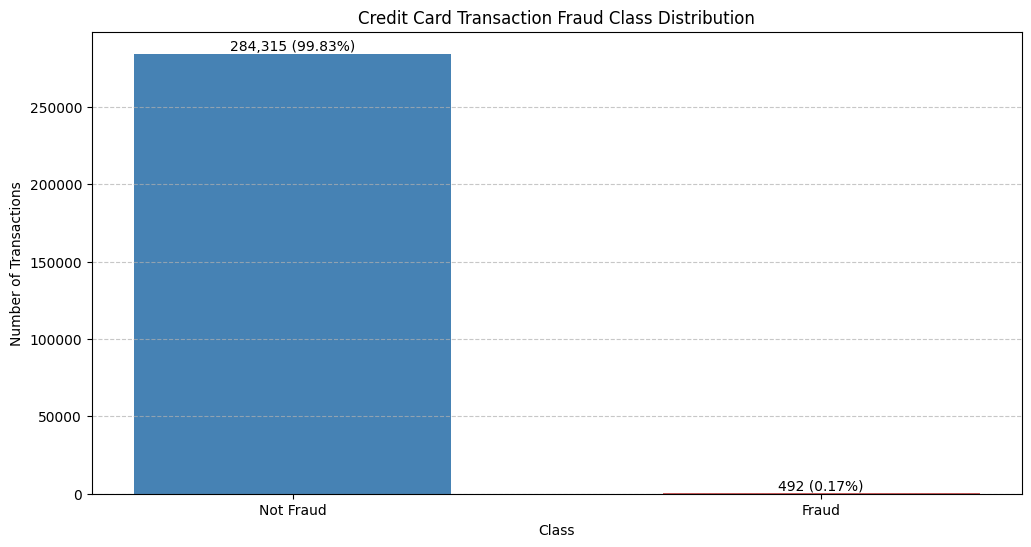

In [5]:
temp = cc["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index, 'values': temp.values})

total = temp.sum()
df['percent'] = df['values'] / total * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(df['Class'], df['values'], color=['steelblue', 'indianred'], width=0.6)
for bar, value, percent in zip(bars, df['values'], df['percent']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{value:,} ({percent:.2f}%)', ha='center', va='bottom')
plt.title('Credit Card Transaction Fraud Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.xticks(df['Class'], ['Not Fraud', 'Fraud'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Fraud cases are significantly underrepresented, as they are only 0.17% of the entire dataset. This severe class imbalance will cause challenges with traditional classification models, as they show a bias towards the majority class. Because of this, metrics such as Precision-Recall AUC will be explored, as they provide a more informative evaluation for imbalanced datasets.

### Transaction Time Density

Fraud and non-fraud transactions may differ in temporal patterns. We can analyze the transaction density over time to spot any significant differences.

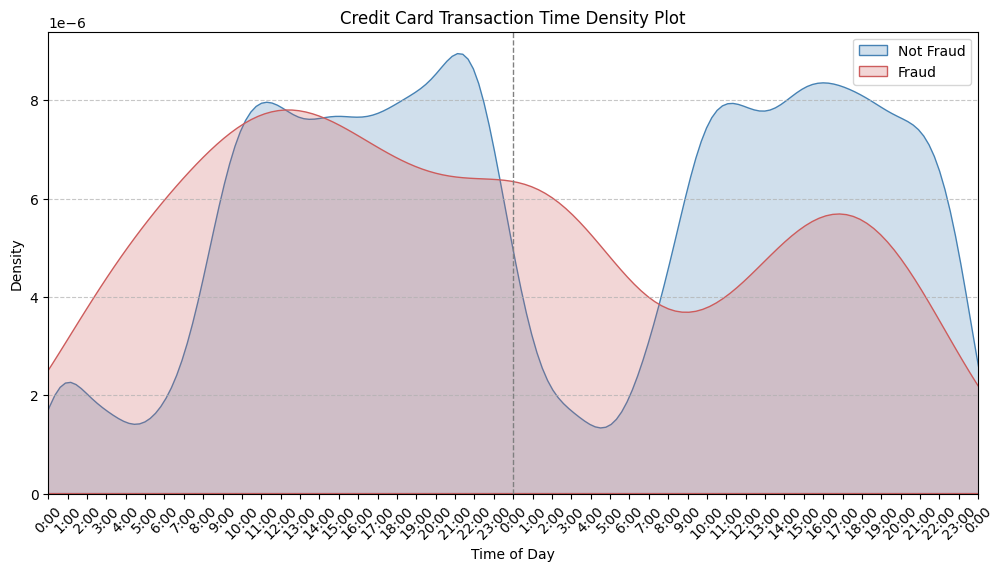

In [6]:
class_0 = cc.loc[cc['Class'] == 0]["Time"]
class_1 = cc.loc[cc['Class'] == 1]["Time"]

plt.figure(figsize=(12, 6))
sns.kdeplot(class_0, label='Not Fraud', fill=True, color='steelblue')
sns.kdeplot(class_1, label='Fraud', fill=True, color='indianred')
plt.title('Credit Card Transaction Time Density Plot')
plt.xlabel('Time of Day')
plt.ylabel('Density')
plt.xlim(0, max(cc["Time"]))
hour_labels = [f'{i % 24}:00' for i in range(49)] # 0:00 to 23:00 repeated twice
plt.xticks(ticks=[i * 3600 for i in range(49)], labels=hour_labels, rotation=45)
plt.axvline(x=24 * 3600, color='gray', linestyle='--', linewidth=1)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Non-fraud transactions exhibit peaks during typical waking hours and dips at night, consistent with human activity patterns, In contrast, fraud transactions are distributed more uniformly over time.

### Feature Density and KL Divergence

A feature density plot is used to compare the distribution of each feature for non-fraudulent and fraudulent transactions. By analyzing these distributions, we can try to identify which features are most indicative of fraud. Kullback-Leibler (KL) Divergence is used to quantify the differences between the two classes for each feature.

<Figure size 1600x2800 with 0 Axes>

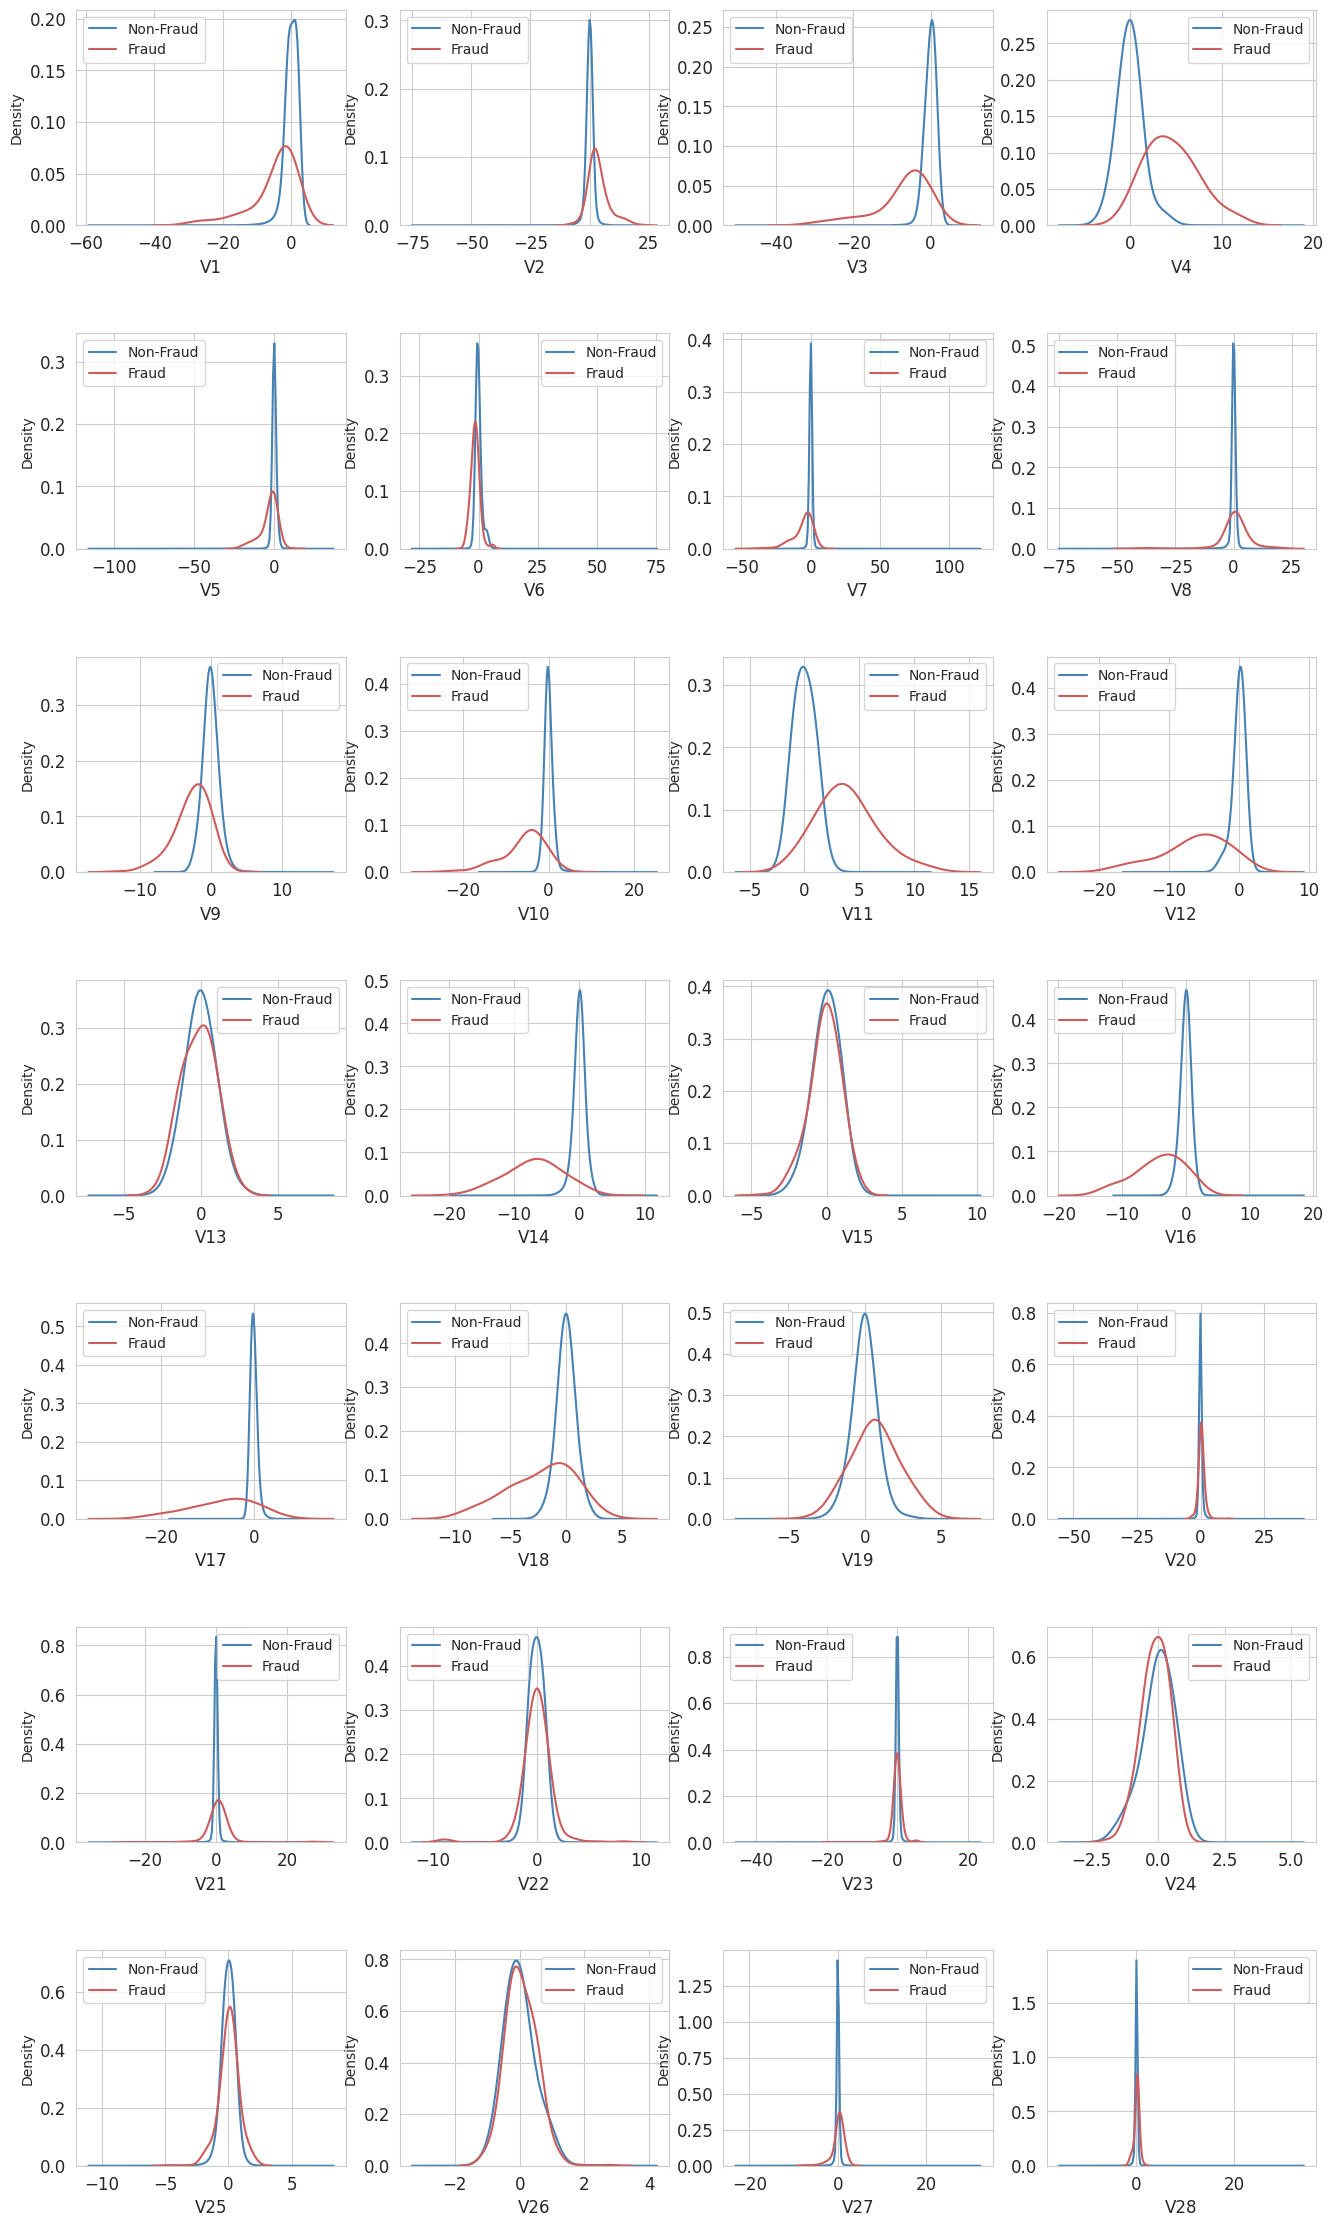

In [7]:
c0 = cc.loc[cc['Class'] == 0]
c1 = cc.loc[cc['Class'] == 1]

sns.set_style('whitegrid')
plt.figure(figsize=(16, 28))
fig, ax = plt.subplots(7, 4, figsize=(16, 28))
fig.subplots_adjust(hspace=0.5)
kl_divergences = {}

i = 0
for feature in cc.columns[1:29]:
    i += 1
    plt.subplot(7, 4, i)
    if c0[feature].var() == 0 or c1[feature].var() == 0:
        continue
    sns.kdeplot(c0[feature], bw_method=0.5, label="Non-Fraud", color='steelblue')
    sns.kdeplot(c1[feature], bw_method=0.5, label="Fraud", color='indianred')
    plt.xlabel(feature, fontsize=12)
    plt.legend()
    plt.tick_params(axis='both', which='major', labelsize=12)
    # Calculate KL Divergence
    min_val = min(c0[feature].min(), c1[feature].min())
    max_val = max(c0[feature].max(), c1[feature].max())
    range_bins = np.linspace(min_val, max_val, 100)
    p, _ = np.histogram(c0[feature], bins=range_bins, density=True)
    q, _ = np.histogram(c1[feature], bins=range_bins, density=True)
    epsilon = 1e-10 # Add small epsilon to avoid log(0) issues
    p = p + epsilon
    q = q + epsilon
    kl_divergence_pq = np.sum(rel_entr(p, q))
    kl_divergence_qp = np.sum(rel_entr(q, p))
    kl_divergence = 0.5 * (kl_divergence_pq + kl_divergence_qp)
    kl_divergences[feature] = kl_divergence

plt.show()

The results show that certain features, such as V15 and V26, have similar distributions between non-fraudulent and fraudulent transactions, implying that these features contribute minimally to distinguishing between the two classes. Features like V3 and V11 show significant differences in their distributions, showing their importance in identifying fraudulent transactions. By calculating KL Divergence, we can further quantify these differences and rank the features by their importance for fraud detection.

The features are ranked by their KL Divergence values to estimate their impact on fraud detection. Higher KL Divergence values indicate greater differences in distributions between fraudulent and non-fraudulent transactions. The top 20 features will be selected for input into the model.

In [8]:
sorted_kl_divergences = sorted(kl_divergences.items(), key=lambda item: item[1], reverse=True)

for feature, kl_divergence in sorted_kl_divergences:
    print(f"Feature: {feature}, KL Divergence: {kl_divergence:.3f}")

Feature: V11, KL Divergence: 24.660
Feature: V4, KL Divergence: 18.592
Feature: V18, KL Divergence: 18.247
Feature: V12, KL Divergence: 17.975
Feature: V14, KL Divergence: 14.446
Feature: V17, KL Divergence: 13.771
Feature: V16, KL Divergence: 12.471
Feature: V9, KL Divergence: 8.721
Feature: V10, KL Divergence: 8.505
Feature: V24, KL Divergence: 7.778
Feature: V26, KL Divergence: 6.865
Feature: V3, KL Divergence: 4.780
Feature: V19, KL Divergence: 4.596
Feature: V13, KL Divergence: 1.918
Feature: V21, KL Divergence: 1.867
Feature: V2, KL Divergence: 1.811
Feature: V27, KL Divergence: 1.797
Feature: V1, KL Divergence: 1.616
Feature: V22, KL Divergence: 1.224
Feature: V8, KL Divergence: 1.103
Feature: V7, KL Divergence: 1.063
Feature: V6, KL Divergence: 0.982
Feature: V25, KL Divergence: 0.898
Feature: V28, KL Divergence: 0.779
Feature: V15, KL Divergence: 0.764
Feature: V5, KL Divergence: 0.615
Feature: V23, KL Divergence: 0.410
Feature: V20, KL Divergence: 0.408


Feature V11 has the highest KL Divergence value of 24.660, implying it is the most informative for fraud detection. Feature V20 has the lowest KL Divergence value of 0.408, implying minimal contribution. Now when inputting the features into the model, we will only keep the top 20 features to prevent overfitting issues.

In [9]:
top_features = sorted([feature for feature, _ in sorted_kl_divergences[:20]], key=lambda x: int(x[1:]))
filtered_features = cc[top_features]

To account for time variations in the data, skewness is calculated for each selected feature within 8-second time windows. This ensures that the analysis captures meaningful temporal patterns that may influence fraud detection.

In [10]:
time_windows = 8 # in seconds
num_windows = int(cc["Time"].max() // time_windows)

stat_features = pd.DataFrame()

for feature in filtered_features.columns: 
    stat_features[f'{feature}'] = cc.groupby(cc['Time'] // time_windows)[feature].transform('skew') # Calculate skewness

features = stat_features

### Correlation Matrix

A correlation matrix visualizes the linear relationships between the selected features. Each cell represents the correlation coefficient between two features, with values ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation). This helps identify pairs of features that are highly correlated, which may influence model performance.

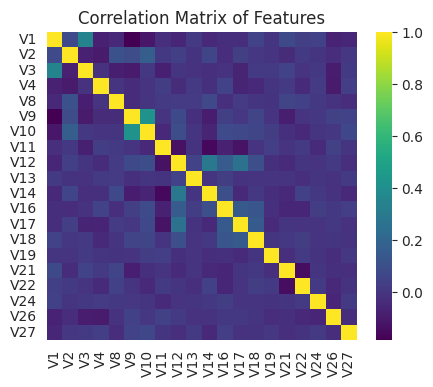

In [11]:
correlation_matrix = features[filtered_features.columns].corr().values

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', xticklabels=filtered_features.columns, yticklabels=filtered_features.columns)
plt.title(f'Correlation Matrix of Features')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Graphing the Network

To represent the relationships between features as a graph, a threshold is applied to the correlation matrix to create an adjacency matrix. Edges are established between nodes (features) if their correlation exceeds the threshold of 0.025 (arbitrarily set). This threshold ensures the resulting adjacency matrix is invertible.

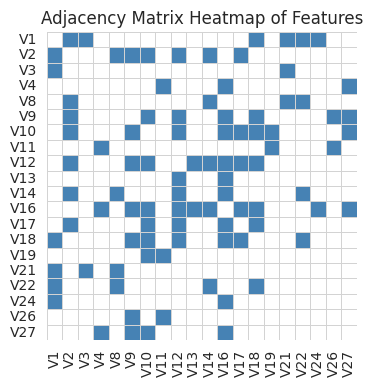

In [12]:
threshold = 0.025 # Threshold for edges
adjacency_matrix = (correlation_matrix > threshold).astype(int)
np.fill_diagonal(adjacency_matrix, 0)
adjacency_df = pd.DataFrame(adjacency_matrix, columns=filtered_features.columns, index=filtered_features.columns)

plt.figure(figsize=(4, 4))
sns.heatmap(adjacency_df, annot=False, cmap=mcolors.ListedColormap(['white', 'steelblue']), cbar=False, linewidths=.5, linecolor='lightgray')
plt.title('Adjacency Matrix Heatmap of Features')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

The adjacency matrix heatmap illustrates which features are connected based on their correlation values. These connections form the foundation of the graph structure.

Next, the adjacency matrix is converted into a NetworkX graph. Each node corresponds to a feature, and edges indicate correlations above the threshold. A seed is set for reproducibility, ensuring consistent graph visualization across runs.

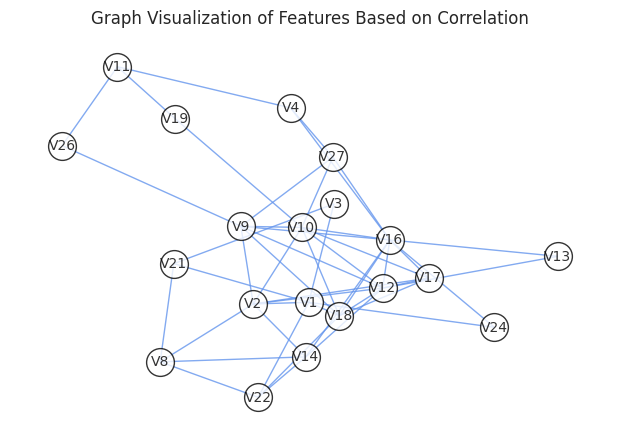

In [13]:
np.random.seed(120)

G = nx.from_numpy_array(adjacency_matrix)
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G)
labels = {i: filtered_features.columns[i] for i in range(len(filtered_features.columns))}
nx.draw(G, pos, labels=labels, node_color='white', edgecolors='black', edge_color='cornflowerblue', node_size=400, alpha=0.8, font_size=10)
plt.title('Graph Visualization of Features Based on Correlation')
plt.show()

The graph visualization provides a clear representation of the feature interactions. Nodes with more connections are more central to the graph, potentially highlighting features with stronger relationships to others.

To ensure the adjacency matrix is suitable for further analysis, its determinant and rank are calculated. A non-zero determinant and full rank confirm its invertibility.

In [14]:
det = np.linalg.det(adjacency_matrix)
rank = np.linalg.matrix_rank(adjacency_matrix)
print(f'Determinant: {det}')
print(f'Rank: {rank}')
print(f'Invertible: {det != 0 and rank == adjacency_matrix.shape[0]}')

edge_index = torch.tensor(np.transpose(np.nonzero(adjacency_matrix)), dtype=torch.long)
x = torch.tensor(filtered_features.values, dtype=torch.float)
y = torch.tensor(cc['Class'].values, dtype=torch.long)

num_edges = edge_index.size(0)
print(f'Number of edges: {num_edges}')

Determinant: 35.99999999999998
Rank: 20
Invertible: True
Number of edges: 94


This structure is now ready for use in training both the GNN and QGNN models. The determinant and rank calculations confirm the adjacency matrix is invertible, ensuring mathematical validity for the subsequent operations.

### Data Split and Preparation

The dataset is split into training (60%), validation (10%), and test sets (30%) using random permutation. Training Data (train_data) is used to train the model. Validation Data (val_data) is used to tune the model and prevent overfitting. Test Data (test_data) is used to evaluate the model's final performance.

To address the class imbalance in the dataset (with far more non-fraud cases than fraud cases), class weights are computed and incorporated into the loss function. This ensures that the model does not disproportionately favor the majority class.

In [15]:
data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)

num_nodes = data.num_nodes
indices = np.random.permutation(num_nodes)
train_split = int(0.6 * num_nodes)
val_split = int(0.7 * num_nodes)

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

train_data = Data(x=data.x[train_indices], edge_index=data.edge_index, y=data.y[train_indices])
val_data = Data(x=data.x[val_indices], edge_index=data.edge_index, y=data.y[val_indices])
test_data = Data(x=data.x[test_indices], edge_index=data.edge_index, y=data.y[test_indices])

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

### Training and Validation Functions

Two key functions are defined to calculate training and validation loss during each epoch. These functions process the data in batches and leverage the DataLoader utility to shuffle and load the data efficiently.

The train function iterates over the training dataset, computes the loss for each batch, and updates the model's parameters using backpropagation. The optimizer's zero_grad() and step() methods ensure the gradients are reset and updated correctly for each batch.

The valid function is used to evaluate the model's performance on the validation dataset. Unlike the training function, this function does not update the model parameters but calculates the loss over the validation set. This provides an unbiased evaluation metric to monitor the model's performance during training.

In [16]:
def train(model, optimizer, data, batch_size=10): # Training
    model.train()
    total_loss = 0
    total_graphs = 0
    data_loader = DataLoader([data], batch_size=batch_size, shuffle=True)
    for batch in data_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        out = model(batch)
        loss = criterion(out.view(-1), batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    return total_loss / total_graphs

def valid(model, data, batch_size=10): # Validation
    model.eval()
    total_loss = 0
    total_graphs = 0
    data_loader = DataLoader([data], batch_size=batch_size, shuffle=True)
    for batch in data_loader:
        batch = batch.to(device)
        out = model(batch)
        loss = criterion(out.view(-1), batch.y.float())
        total_loss += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    return total_loss / total_graphs

## Classical Graph Neural Network

### Model Architecture

The GNN model uses three GraphSAGE convolutional layers, which aggregate information from a node's local neighborhood to generate node-level embeddings. Key components of the model include:

* **GraphSAGE Layers**: Perform neighborhood aggregation and generate node embeddings.
* **Batch Normalization**: Applied after each convolutional layer to stabilize training and improve convergence.
* **GeLU Activation**: A non-linear activation function that introduces smooth transitions and enhances model expressivity.
* **Dense Layer**: Maps the final node embeddings to a single scalar output.
* **Sigmoid Activation**: Outputs probabilities between 0 and 1 for binary classification.

In [17]:
class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(20, 15) # GraphSAGE
        self.bn1 = nn.BatchNorm1d(15) # Batch Normalization
        self.conv2 = SAGEConv(15, 10)
        self.bn2 = nn.BatchNorm1d(10)
        self.conv3 = SAGEConv(10, 5)
        self.bn3 = nn.BatchNorm1d(5)
        self.fc = Linear(5, 1) # Dense Layer
        self.sigmoid = nn.Sigmoid() # Sigmoid Activation

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index) # GraphSAGE
        x = self.bn1(x) # Batch Normalization
        x = F.gelu(x) # GeLU Activation
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.gelu(x)
        x = self.conv3(x, edge_index) 
        x = self.bn3(x)
        x = F.gelu(x)
        x = self.fc(x) # Dense Layer
        x = self.sigmoid(x) # Sigmoid Activation
        return x

### Training

The model is instantiated and trained using the Adam optimizer with a learning rate of 0.01 and weight decay for regularization. Binary Cross-Entropy Loss (BCELoss) is used as the objective function, suitable for binary classification tasks. The training process includes:

* **Training Phase**: The model is trained on the training data to minimize the loss function.
* **Validation Phase**: The validation data is used to monitor performance and detect overfitting.
* **Checkpoints**: Model states are saved after each epoch for potential recovery or further analysis.

In [18]:
torch.manual_seed(120)

def accuracy(outputs, targets):
    preds = (outputs > 0.5).float()
    return (preds == targets).float().mean().item()

model_GNN = GNN().to(device)
optimizer_GNN = optim.Adam(model_GNN.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.BCELoss()

num_epochs = 100
batch_size = 10
train_loss_GNN = []
valid_loss_GNN = []
train_accuracy_GNN = []
valid_accuracy_GNN = []

for epoch in range(num_epochs):
    # Training
    model_GNN.train()
    train_loss = 0
    train_acc = 0
    num_batches = 0
    data_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    for batch in data_loader:
        optimizer_GNN.zero_grad()
        batch = batch.to(device)
        out = model_GNN(batch)
        loss = criterion(out.view(-1), batch.y.float())
        loss.backward()
        optimizer_GNN.step()
        train_loss += loss.item()
        train_acc += accuracy(out.view(-1), batch.y.float())
        num_batches += 1
    train_loss_GNN.append(train_loss / num_batches)
    train_accuracy_GNN.append(train_acc / num_batches)

    # Validation
    model_GNN.eval()
    val_loss = 0
    val_acc = 0
    num_batches = 0
    data_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            out = model_GNN(batch)
            loss = criterion(out.view(-1), batch.y.float())
            val_loss += loss.item()
            val_acc += accuracy(out.view(-1), batch.y.float())
            num_batches += 1
    valid_loss_GNN.append(val_loss / num_batches)
    valid_accuracy_GNN.append(val_acc / num_batches)

To evaluate the model's performance over time, we plot the training and validation loss across all epochs. This visualization helps identify how well the model is learning and whether issues such as overfitting or underfitting are present.

The y-axis is log-scaled to accommodate the wide range of loss values, making it easier to observe trends, especially when losses span several orders of magnitude.

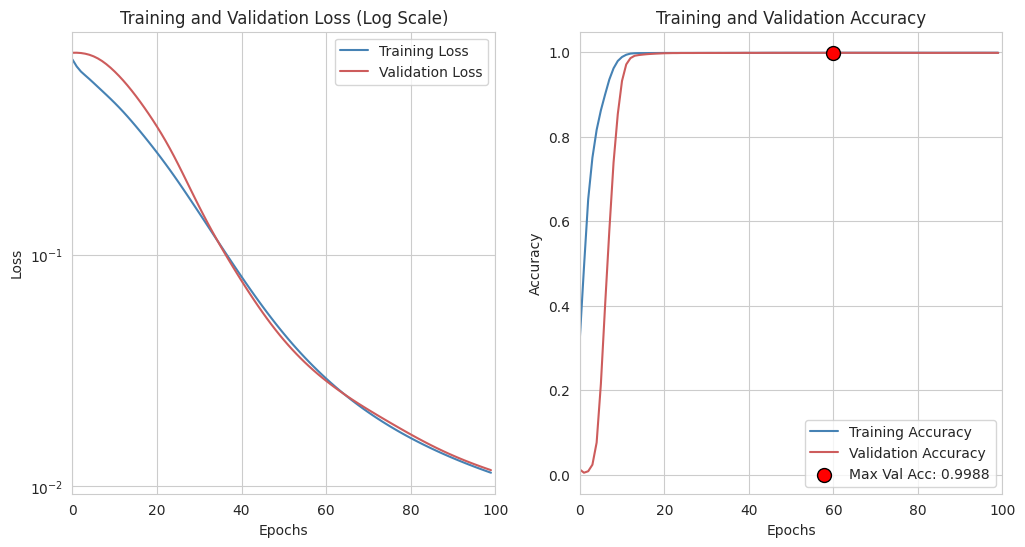

In [19]:
# Find the best epochs for training and validation accuracy
best_train_epoch = max(enumerate(train_accuracy_GNN), key=lambda x: x[1])
best_val_epoch = max(enumerate(valid_accuracy_GNN), key=lambda x: x[1])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_GNN, color='steelblue', label='Training Loss')
plt.plot(valid_loss_GNN, color='indianred', label='Validation Loss')
plt.xlim(0, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_GNN, color='steelblue', label='Training Accuracy')
plt.plot(valid_accuracy_GNN, color='indianred', label='Validation Accuracy')
plt.scatter(best_val_epoch[0], best_val_epoch[1], color='red', s=100, label=f'Max Val Acc: {best_val_epoch[1]:.4f}', edgecolors='black', zorder=5)
plt.xlim(0, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

It is important that this graph shows that training loss is less than validation loss, this implies that the model is learning patterns from the data properly and is generalizing well to unseen data. This occurs at roughly 100 epochs, so I had arbitrarily decided to stop running the model at that point.

### Confusion Matrix and Classification Report

To evaluate the model's performance, predicted probabilities are converted into binary classifications using a threshold. If the predicted probability exceeds the threshold (default of 0.5), the transaction is classified as fraud (1); otherwise, it's classified as non-fraud (0). The optimal threshold is determined by maximizing the $F_1$-score, which balances precision and recall.

The confusion matrix provides a summary of the model's predictions, displaying the counts for true positives, true negatives, false positives, and false negatives. This helps identify where the model performs well and where it might be making errors.

The classification report offers additional metrics, such as Precision, Recall, and $F_1$-score for both classes, giving a more comprehensive evaluation of the model's predictive power.

In [20]:
def evaluate_classification(model, data, batch_size=10, threshold=None):
    model.eval()
    predictions = []
    true_labels = []
    probs_list = []
    data_loader = DataLoader([data], batch_size=batch_size, shuffle=False)
    for batch in data_loader:
        batch = batch.to(device)
        out = model(batch)
        probs = torch.sigmoid(out).squeeze()
        probs_list.extend(probs.detach().cpu().numpy())
        true_labels.append(batch.y.cpu().numpy())
    probs_array = np.array(probs_list)
    true_labels = np.concatenate(true_labels)
    if threshold is not None:
        best_threshold_GNN = threshold
        preds = (probs_array > best_threshold_GNN).astype(int)
        best_f1_GNN = f1_score(true_labels, preds)
    else:
        best_threshold_GNN = 0.5
        best_f1_GNN = 0.0
        thresholds = np.linspace(0, 1, 1000)
        for threshold in thresholds:
            preds = (probs_array > threshold).astype(int)
            f1 = f1_score(true_labels, preds)
            if f1 > best_f1_GNN:
                best_f1_GNN = f1
                best_threshold_GNN = threshold
    final_predictions = (probs_array > best_threshold_GNN).astype(int)
    return final_predictions, true_labels, probs_array, best_threshold_GNN, best_f1_GNN

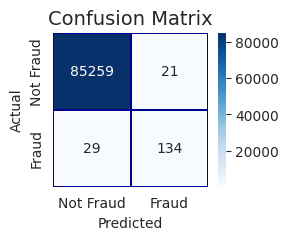

Classification Report:
              precision    recall  f1-score   support

   Not Fraud     0.9997    0.9998    0.9997     85280
       Fraud     0.8645    0.8221    0.8428       163

    accuracy                         0.9994     85443
   macro avg     0.9321    0.9109    0.9212     85443
weighted avg     0.9994    0.9994    0.9994     85443



In [21]:
test_pred_GNN, test_true_GNN, test_prob_GNN, best_threshold_GNN, best_f1_GNN = evaluate_classification(model_GNN, test_data)

# Confusion Matrix
cm_GNN = pd.crosstab(test_true_GNN, test_pred_GNN, rownames=['Actual'], colnames=['Predicted'])
fig, ax1 = plt.subplots(ncols=1, figsize=(2.5, 2))
sns.heatmap(cm_GNN, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'],
            annot=True, ax=ax1, fmt='g', linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Classification Report
class_report_GNN = classification_report(test_true_GNN, test_pred_GNN, target_names=['Not Fraud', 'Fraud'], digits=4)
print("Classification Report:")
print(class_report_GNN)

The high precision (0.8645), recall (0.8221), and $F_1$-scores (0.8428) achieved for fraud cases indicate that the GNN model performs effectively in detecting fraudulent cases, this is a good result especially since our dataset is highly imbalanced. These results will be used as a benchmark to compare against the QGNN model results.

### Receiver Operating Characteristic Curve

The Receiver Operating Characteristic (ROC) Curve provides a visual representation of the trade-off between the True Positive Rate and the False Positive Rate at various threshold settings. It evaluates how well the model can distinguish between classes across all possible thresholds.

The Receiver Operating Characteristic Area Under the Curve (ROC AUC) is a value summarizing the ROC curve. A higher ROC AUC value, closer to 1.0, indicates better model performance.

In [22]:
def evaluate_roc(model, data, batch_size=10, return_probs=False):
    model.eval()
    probabilities = []
    true_labels = []
    data_loader = DataLoader([data], batch_size=batch_size, shuffle=False)

    for batch in data_loader:
        batch = batch.to(device)
        out = model(batch)
        probs = torch.sigmoid(out).squeeze().detach()

        if return_probs:
            probabilities.append(probs.cpu().numpy())
        else:
            pred = (probs > 0.5).long()
            probabilities.append(pred.cpu().numpy())
        true_labels.append(batch.y.cpu().numpy())

    return np.concatenate(probabilities), np.concatenate(true_labels)

ROC AUC: 0.9541


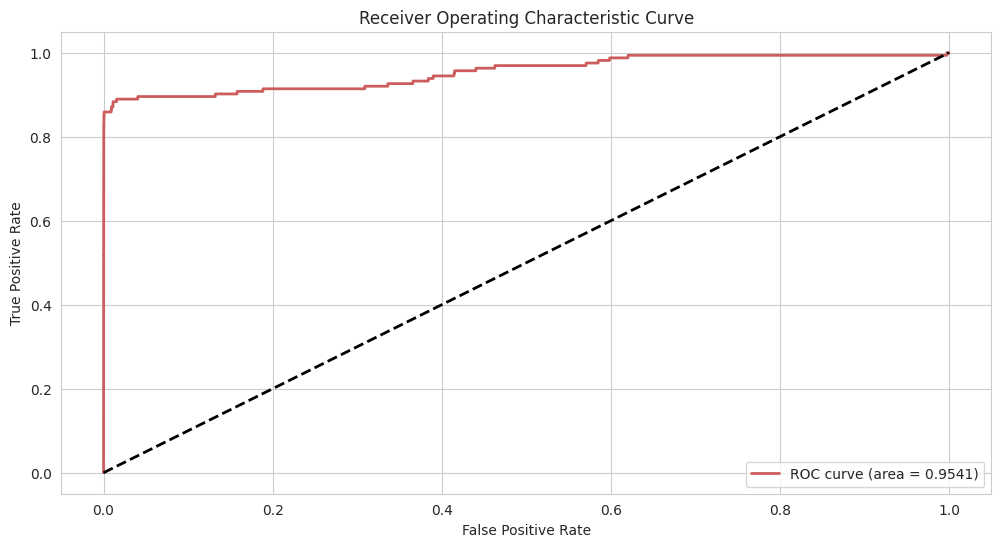

In [23]:
test_prob_GNN, test_true_GNN = evaluate_roc(model_GNN, test_data, return_probs=True)

fpr_GNN, tpr_GNN, _ = roc_curve(test_true_GNN, test_prob_GNN)
roc_auc_GNN = auc(fpr_GNN, tpr_GNN)
print(f"ROC AUC: {roc_auc_GNN:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(fpr_GNN, tpr_GNN, color='indianred', lw=2, label=f'ROC curve (area = {roc_auc_GNN:.4f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

As shown by a ROC AUC score of 0.9541, the GNN model demonstrates high discrimination power, proving its effectiveness in identifying fraudulent transactions in this imbalanced dataset. The result may look good, but since we are dealing with an imbalanced dataset it is better to use the PR Curve as a measure.

### Precision-Recall Curve

The Precision-Recall Curve provides a detailed view of the trade-off between precision and recall across different thresholds. This is especially useful for imbalanced datasets, such as this one, where fraud transactions represent a small fraction of the total transactions. precision measures the accuracy of positive predictions, while recall indicates the ability to identify all positive instances.

The Precision-Recall Area Under the Curve (PR AUC) summarizes this relationship into a single scalar value. It highlights the model's capability to balance false positives and true positives, which is critical in fraud detection. In imbalanced datasets, PR AUC is often a more informative metric than standard AUC, as it focuses on the minority class.

In [24]:
def evaluate_prc(model, data, batch_size=10, return_probs=False):
    model.eval()
    predictions = []
    true_labels = []
    data_loader = DataLoader([data], batch_size=batch_size, shuffle=False)
    for batch in data_loader:
        batch = batch.to(device)
        out = model(batch)
        probs = torch.sigmoid(out).squeeze()
        if return_probs:
            predictions.append(probs.cpu().detach().numpy())
        else:
            pred = (probs > 0.5).long()
            predictions.append(pred.cpu().numpy())
        true_labels.append(batch.y.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_labels)

Precision-Recall AUC: 0.7843


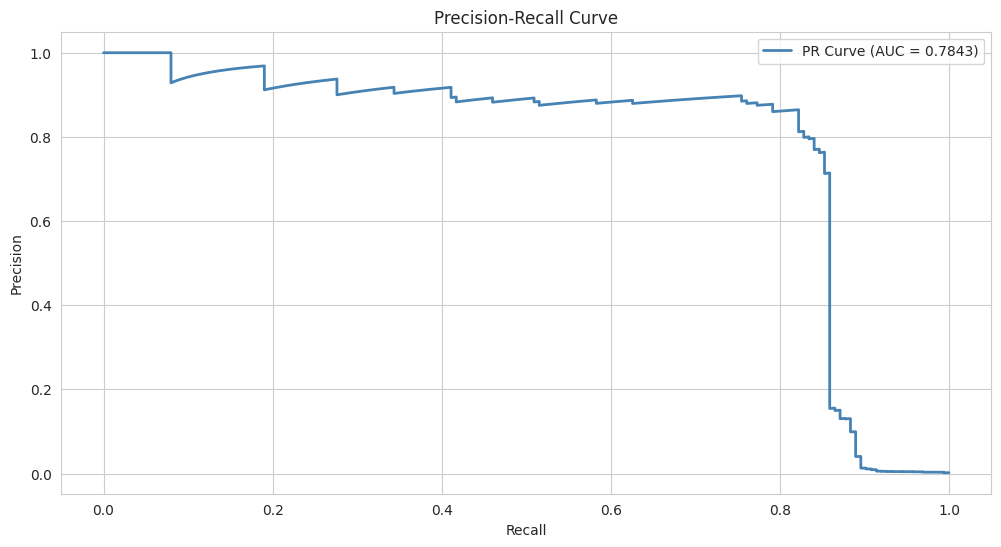

In [25]:
test_prob_GNN, test_true_GNN = evaluate_prc(model_GNN, test_data, batch_size=10, return_probs=True)

precision_GNN, recall_GNN, _ = precision_recall_curve(test_true_GNN, test_prob_GNN)
pr_auc_GNN = auc(recall_GNN, precision_GNN)
print(f'Precision-Recall AUC: {pr_auc_GNN:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(recall_GNN, precision_GNN, color='steelblue', lw=2, label=f'PR Curve (AUC = {pr_auc_GNN:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

The PR AUC Score of 0.7843 is excellent, highlighting the GNN model's ability to identify the fraudulent transactions. This will also be used as a benchmark to evaluate the QGNN model's score.

## Quantum Graph Neural Network

### Load Packages

In order to successfully run the CUDA-Q code in this project with GPU-acceleration, check the NVIDIA site for instructions (https://nvidia.github.io/cuda-quantum/latest/using/quick_start.html#install-cuda-q).

In [26]:
# CUDA Quantum Libraries
import cudaq
from cudaq import spin

# Set CUDA Quantum target to NVIDIA
cudaq.set_target("nvidia")  

### Quantum Function Setup

We first define the parameters for the quantum computation. The qubit_count specifies the number of qubits used in the quantum circuit. The hamiltonian is the measurement operator, defined as the Z-spin operator. The shift value of $\frac{π}{2}$ is used for the parameter-shift rule in gradient computation.

In [27]:
qubit_count = 1
hamiltonian = spin.z(0) # Measurement operator
shift = torch.tensor(torch.pi / 2) # Parameter shift

The QuantumFunction class defines the quantum circuit and integrates it into PyTorch. The circuit applies rotation gates ($r_y$, $r_x$) to the qubits and uses $c_x$ gates for entanglement if multiple qubits are used. The run method executes the circuit and computes the expectation values based on the Hamiltonian. The forward and backward methods handle the data flow and gradient computation.

In [28]:
class QuantumFunction(Function):
    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        @cudaq.kernel
        def kernel(qubit_count: int, thetas: np.ndarray):
            qubits = cudaq.qvector(qubit_count)
            for i in range(qubit_count):
                ry(thetas[0], qubits[i]) # Rotation Y
            if qubit_count > 1:
                for j in range(qubit_count - 1):
                    cx(qubits[j], qubits[j + 1]) # Entanglement
            for i in range(qubit_count):
                rx(thetas[1], qubits[i]) # Rotation X
        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

    def run(self, theta_vals: torch.tensor) -> torch.tensor:
        qubit_count = [self.qubit_count for _ in range(theta_vals.shape[0])]
        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count, theta_vals)
        exp_vals = [results[i].expectation() for i in range(len(results))]
        return torch.Tensor(exp_vals).to(device)

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit, shift) -> torch.tensor:
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        exp_vals = ctx.quantum_circuit.run(thetas).reshape(-1, 1)
        ctx.save_for_backward(thetas, exp_vals)
        return exp_vals

    @staticmethod
    def backward(ctx, grad_output):
        thetas, _ = ctx.saved_tensors
        gradients = torch.zeros(thetas.shape, device=device)
        for i in range(thetas.shape[1]):
            thetas_plus = thetas.clone()
            thetas_plus[:, i] += ctx.shift
            exp_vals_plus = ctx.quantum_circuit.run(thetas_plus)
            
            thetas_minus = thetas.clone()
            thetas_minus[:, i] -= ctx.shift
            exp_vals_minus = ctx.quantum_circuit.run(thetas_minus)
            
            gradients[:, i] = (exp_vals_plus - exp_vals_minus) / (2 * ctx.shift)
        return torch.mul(grad_output, gradients), None, None

The QuantumLayer class wraps the QuantumFunction into a PyTorch layer. This allows integration of the quantum circuit into a hybrid quantum-classical neural network. The forward method applies the quantum circuit to the input features and returns the resulting quantum-enhanced features.

In [29]:
class QuantumLayer(nn.Module):
    def __init__(self, qubit_count: int, hamiltonian, shift: torch.tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input):
        return QuantumFunction.apply(input, self.quantum_circuit, self.shift)

### Model Architecture

The QGNN model combines classical graph convolutional networks with quantum enhancements to create a hybrid architecture. The key components of the model include:

* **Graph Convolutional Layer (GCN)**: A single SGConv layer is used to aggregate information from a node's neighborhood and generate node embeddings. This layer replaces the multiple GraphSAGE layers used in the classical GNN to simplify the structure.
* **Quantum Layer**: A Variational Quantum Circuit (VQC) enhances the node embeddings by capturing non-linear and complex interactions that are difficult to model classically. This layer integrates quantum computations into the model pipeline.
* **Adaptive Average Pooling**: Aggregates node-level features into a graph-level representation, reducing the feature dimensions and preparing the data for the final layers.
* **Dense Layer**: Maps the pooled quantum-enhanced features to a single scalar output, representing the classification score.
* **Sigmoid Activation**: Converts the output into a probability between 0 and 1, suitable for binary classification tasks.

In [30]:
class QGNN(nn.Module):
    def __init__(self):
        super(QGNN, self).__init__()
        self.conv1 = SGConv(20, 2 * qubit_count) # SGConv
        self.quantum = QuantumLayer(qubit_count, hamiltonian, shift) # Quantum
        self.linear = nn.Linear(1, 1) # Dense Layer
        self.sigmoid = nn.Sigmoid() # Sigmoid Activation

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index) # SGConv
        x = F.relu(x) # ReLU Activation
        x = self.quantum(x) # Quantum
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x

In [31]:
torch.manual_seed(120)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.7, gamma=5.5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        return (self.alpha * (1 - pt) ** self.gamma * BCE_loss).mean()

model_QGNN = QGNN().to(device)
optimizer_QGNN = optim.Adam(model_QGNN.parameters(), lr=0.01, weight_decay=1e-4)
criterion = FocalLoss()

num_epochs = 220
batch_size = 10
train_loss_QGNN = []
valid_loss_QGNN = []
train_accuracy_QGNN = []
valid_accuracy_QGNN = []

for epoch in range(num_epochs):
    # Training
    model_QGNN.train()
    train_loss = 0
    train_acc = 0
    num_batches = 0
    data_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    for batch in data_loader:
        optimizer_QGNN.zero_grad()
        batch = batch.to(device)
        out = model_QGNN(batch)
        loss = criterion(out.view(-1), batch.y.float())
        loss.backward()
        optimizer_QGNN.step()
        train_loss += loss.item()
        train_acc += accuracy(out.view(-1), batch.y.float())
        num_batches += 1
    train_loss_QGNN.append(train_loss / num_batches)
    train_accuracy_QGNN.append(train_acc / num_batches)

    # Validation
    model_QGNN.eval()
    val_loss = 0
    val_acc = 0
    num_batches = 0
    data_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            out = model_QGNN(batch)
            loss = criterion(out.view(-1), batch.y.float())
            val_loss += loss.item()
            val_acc += accuracy(out.view(-1), batch.y.float())
            num_batches += 1
    valid_loss_QGNN.append(val_loss / num_batches)
    valid_accuracy_QGNN.append(val_acc / num_batches)

Once again, we can plot the training and validation loss across all epochs, this helps us identify how well the model is learning and whether issues such as overfitting or underfitting are present.

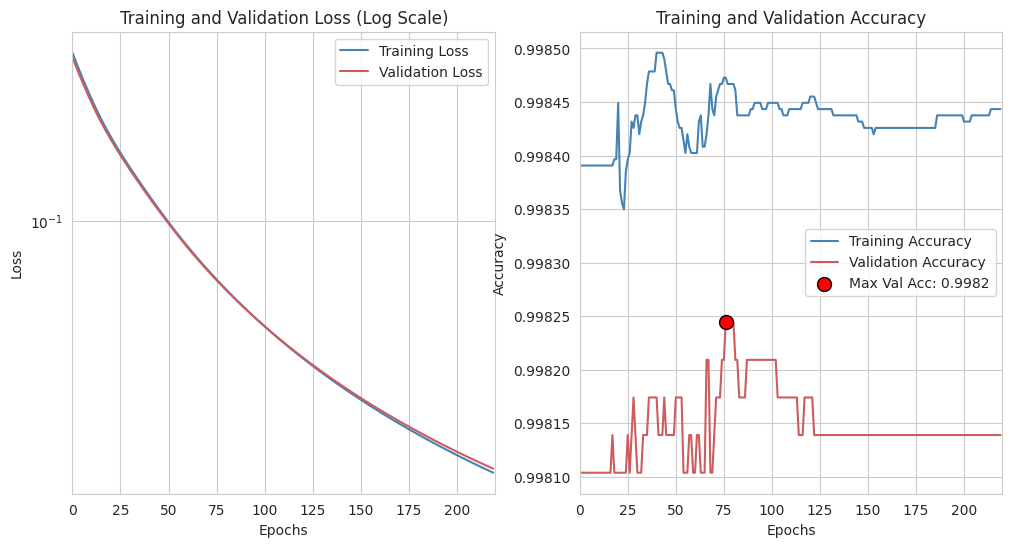

In [32]:
# Find the best epochs for training and validation accuracy
best_train_epoch = max(enumerate(train_accuracy_QGNN), key=lambda x: x[1])
best_val_epoch = max(enumerate(valid_accuracy_QGNN), key=lambda x: x[1])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_QGNN, color='steelblue', label='Training Loss')
plt.plot(valid_loss_QGNN, color='indianred', label='Validation Loss')
plt.xlim(0, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_QGNN, color='steelblue', label='Training Accuracy')
plt.plot(valid_accuracy_QGNN, color='indianred', label='Validation Accuracy')
plt.scatter(best_val_epoch[0], best_val_epoch[1], color='red', s=100, label=f'Max Val Acc: {best_val_epoch[1]:.4f}', edgecolors='black', zorder=5)
plt.xlim(0, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

When the model reaches 200 epochs, the training loss is lower than the validation loss, which is as expected in any well-optimized model.

### Confusion Matrix and Classification Report

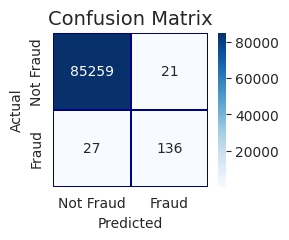

Classification Report:
              precision    recall  f1-score   support

   Not Fraud     0.9997    0.9998    0.9997     85280
       Fraud     0.8662    0.8344    0.8500       163

    accuracy                         0.9994     85443
   macro avg     0.9330    0.9171    0.9249     85443
weighted avg     0.9994    0.9994    0.9994     85443



In [33]:
test_pred_QGNN, test_true_QGNN, test_prob_QGNN, best_threshold_QGNN, best_f1_QGNN = evaluate_classification(model_QGNN, test_data)

# Confusion Matrix
cm_QGNN = pd.crosstab(test_true_QGNN, test_pred_QGNN, rownames=['Actual'], colnames=['Predicted'])
fig, ax1 = plt.subplots(ncols=1, figsize=(2.5, 2))
sns.heatmap(cm_QGNN, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'],
            annot=True, ax=ax1, fmt='g', linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Classification Report
class_report_QGNN = classification_report(test_true_QGNN, test_pred_QGNN, target_names=['Not Fraud', 'Fraud'], digits=4)
print("Classification Report:")
print(class_report_QGNN)

The QGNN model gives us a high precision score (0.8662), recall score (0.8344), and $F_1$-score (0.8500). When compared to the GNN model however, the QGNN model produces higher scores for all 3 of these measures. The QGNN model boasts only a slightly higher precision score than the GNN's 0.8645. The largest improvement is in the QGNN's recall score, which is larger than the GNN's equivalent score of 0.8221. Likewise, the QGNN's $F_1$-score is greater than the GNN's equivalent score of 0.8428.

### Receiver Operating Characteristic (ROC) Curve

ROC AUC: 0.9679


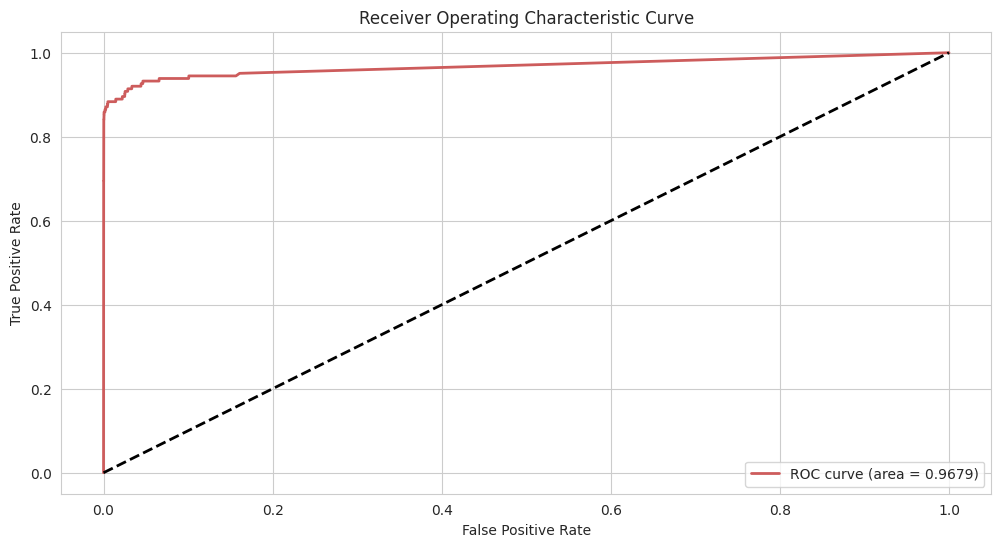

In [34]:
test_prob_QGNN, test_true_QGNN = evaluate_roc(model_QGNN, test_data, return_probs=True)

fpr_QGNN, tpr_QGNN, _ = roc_curve(test_true_QGNN, test_prob_QGNN)
roc_auc_QGNN = auc(fpr_QGNN, tpr_QGNN)
print(f"ROC AUC: {roc_auc_QGNN:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(fpr_QGNN, tpr_QGNN, color='indianred', lw=2, label=f'ROC curve (area = {roc_auc_QGNN:.4f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

The real results for the QGNN model lies here. The QGNN model produces an ROC AUC score of 0.9791, which is a more significant improvement over the GNN model's ROC AUC score of 0.9565, implying that the QGNN model has a better performance as a binary classification model (fraud vs non-fraud).

### Precision-Recall Curve

Precision-Recall AUC: 0.8080


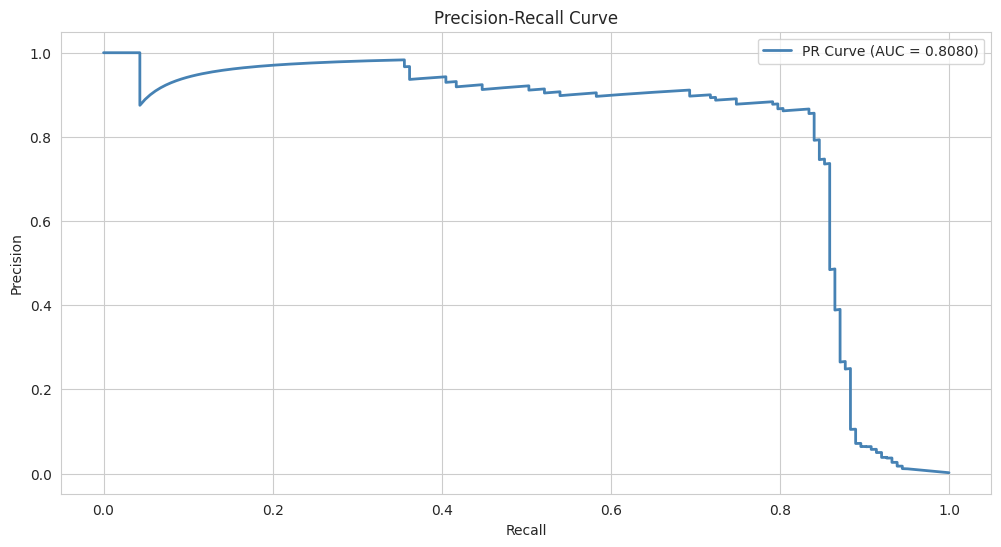

In [35]:
test_prob_QGNN, test_true_QGNN = evaluate_prc(model_QGNN, test_data, batch_size=10, return_probs=True)

precision_QGNN, recall_QGNN, _ = precision_recall_curve(test_true_QGNN, test_prob_QGNN)
pr_auc_QGNN = auc(recall_QGNN, precision_QGNN)
print(f'Precision-Recall AUC: {pr_auc_QGNN:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(recall_QGNN, precision_QGNN, color='steelblue', lw=2, label=f'PR Curve (AUC = {pr_auc_QGNN:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

The QGNN model's PR AUC score (0.8080) is also an improvement over the GNN model's PR AUC score (0.7868), implying that the QGNN model performs better in classifying fraud cases where fraud cases are rare (i.e. an imbalanced dataset).

## Comparison

To aid us visually in understanding the results, we can compare the graphs side-by-side.

### Receiver Operating Characteristic (ROC) Curve

ROC AUC GNN: 0.9541
ROC AUC QGNN: 0.9679


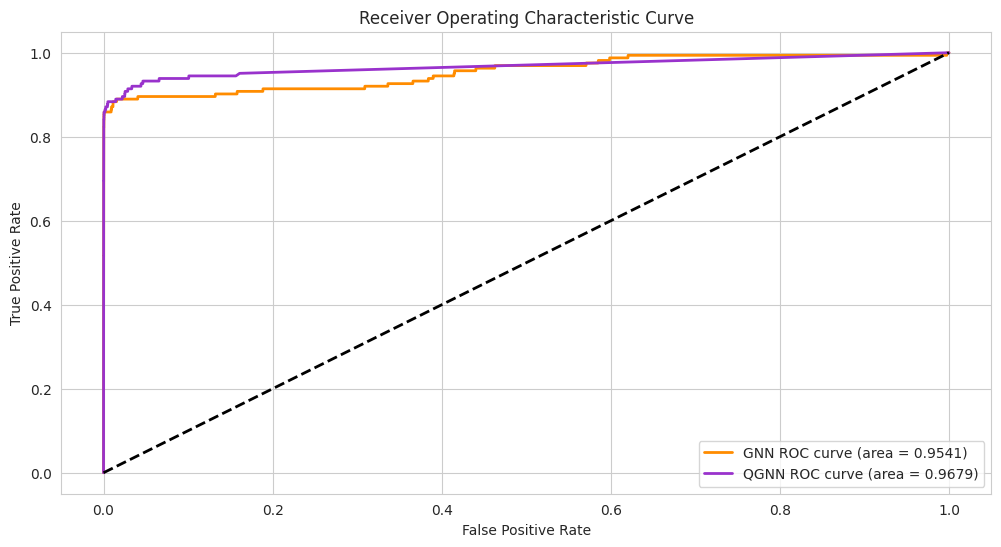

In [36]:
print(f"ROC AUC GNN: {roc_auc_GNN:.4f}")
print(f"ROC AUC QGNN: {roc_auc_QGNN:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(fpr_GNN, tpr_GNN, color='darkorange', lw=2, label=f'GNN ROC curve (area = {roc_auc_GNN:.4f})')
plt.plot(fpr_QGNN, tpr_QGNN, color='darkorchid', lw=2, label=f'QGNN ROC curve (area = {roc_auc_QGNN:.4f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.savefig('AUC_ROC.png')
plt.show()

The QGNN's ROC curve (in purple) shows an improvement over the GNN's ROC curve (in orange), showcasing again how the QGNN model is an improvement over the GNN model in binary classification.

### Precision-Recall Curve

Precision-Recall AUC GNN: 0.7843
Precision-Recall AUC QGNN: 0.8080


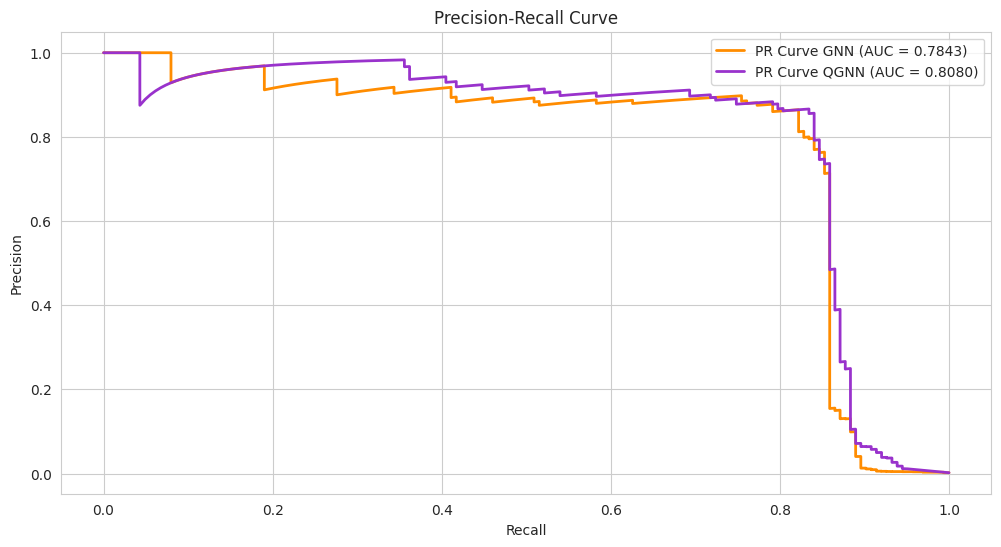

In [37]:
print(f'Precision-Recall AUC GNN: {pr_auc_GNN:.4f}')
print(f'Precision-Recall AUC QGNN: {pr_auc_QGNN:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(recall_GNN, precision_GNN, color='darkorange', lw=2, label=f'PR Curve GNN (AUC = {pr_auc_GNN:.4f})')
plt.plot(recall_QGNN, precision_QGNN, color='darkorchid', lw=2, label=f'PR Curve QGNN (AUC = {pr_auc_QGNN:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

The PR Curve above also shows the same comparison and result, where the QGNN model performs better in classifying fraudulent cases given an imbalanced dataset. This is arguably the more important result of the two.

### Confusion Matrix Figures

In [38]:
precision_score_GNN = precision_score(test_true_GNN, test_pred_GNN)
recall_score_GNN = recall_score(test_true_GNN, test_pred_GNN)
f1_GNN = f1_score(test_true_GNN, test_pred_GNN)

precision_score_QGNN = precision_score(test_true_QGNN, test_pred_QGNN)
recall_score_QGNN = recall_score(test_true_QGNN, test_pred_QGNN)
f1_QGNN = f1_score(test_true_QGNN, test_pred_QGNN)

print(f"{'Model':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'ROC AUC':<10} {'PR AUC':<10}")
print("-" * 60)
print(f"{'GNN':<10} {precision_score_GNN:<10.4f} {recall_score_GNN:<10.4f} {f1_GNN:<10.4f} {roc_auc_GNN:<10.4f} {pr_auc_GNN:<10.4f}")
print(f"{'QGNN':<10} {precision_score_QGNN:<10.4f} {recall_score_QGNN:<10.4f} {f1_QGNN:<10.4f} {roc_auc_QGNN:<10.4f} {pr_auc_QGNN:<10.4f}")

Model      Precision  Recall     F1 Score   ROC AUC    PR AUC    
------------------------------------------------------------
GNN        0.8645     0.8221     0.8428     0.9541     0.7843    
QGNN       0.8662     0.8344     0.8500     0.9679     0.8080    


This is merely repeating the above, we see that the QGNN model beats the GNN model in all of these metrics. More results can be seen on the Github link.